In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy as sp
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer

## Data cleanup

In [1]:
data_bb = pd.read_csv(filepath_or_buffer='./00437.-r_integration-nightly-value.2023-03-01_00-26-24.table.csv',sep='\t',header=2,index_col=0)

NameError: name 'pd' is not defined

In [18]:
data_bb.head()

,Unnamed: 1,status,CPU Time (s),Wall Time (s),Memory (MB),Size of reached set,Number of iterations,Number of abstraction computations,Solving time,Number of variables per state,...,Number of functions,Number of loops (and loop nodes),Number of reached locations,Avg states per location,Max states per location,Number of reached functions,Number of partitions,Avg size of partitions,Max size of partitions,Number of target states
../programs/benchmarks/,,,,,,,,,,,,,,,,,,,,,
array-examples/data_structures_set_multi_proc_ground-1.yml,False,TIMEOUT,973.162137,946.412579,7499.997184,121722.0,121751.0,121757.0,NaN,1.00,...,5.0,8.0,6.0,20287.0,40573.0,1.0,6.0,20287.0,40573.0,0.0
array-examples/data_structures_set_multi_proc_ground-2.yml,True,TIMEOUT,965.421301,939.861896,7499.997184,123015.0,123044.0,123050.0,NaN,1.00,...,5.0,8.0,6.0,20502.0,41004.0,1.0,6.0,20502.0,41004.0,0.0
array-examples/data_structures_set_multi_proc_trivial_ground.yml,True,TIMEOUT,963.935727,940.816955,7499.997184,122329.0,122358.0,122364.0,NaN,1.00,...,5.0,10.0,6.0,20388.0,40776.0,1.0,6.0,20388.0,40776.0,0.0
array-examples/relax-2-2.yml,True,TIMEOUT,901.368846,825.227829,377.851904,79.0,135.0,164.0,NaN,0.43,...,7.0,5.0,66.0,1.0,2.0,5.0,77.0,1.0,2.0,1.0
array-examples/sanfoundry_02_ground.yml,True,TIMEOUT,990.881119,951.452243,7499.997184,126585.0,126620.0,126628.0,NaN,1.00,...,3.0,4.0,6.0,21097.0,42194.0,1.0,6.0,21097.0,42194.0,0.0


In [19]:
data_clean = data_bb

#drop tasks with status TIMEOUT and unknown
index_drop = data_clean[data_clean['status'] == 'TIMEOUT'].index
data_clean = data_clean.drop(index_drop)
index_drop = data_clean[data_clean['status'] == 'unknown'].index
data_clean = data_clean.drop(index_drop)

#Drop completely empty columns(such as Solver time in value analysis)
data_clean = data_clean.dropna(axis='columns',how='all')

In [20]:
data_clean.describe()

,CPU Time (s),Wall Time (s),Memory (MB),Size of reached set,Number of iterations,Number of abstraction computations,Number of variables per state,Number of global variables per state,Number of assumptions,Number of deterministic assumptions,...,Number of functions,Number of loops (and loop nodes),Number of reached locations,Avg states per location,Max states per location,Number of reached functions,Number of partitions,Avg size of partitions,Max size of partitions,Number of target states
count,3799.000000,3799.000000,3799.000000,3.781000e+03,3.781000e+03,3.781000e+03,3781.000000,3781.000000,3.781000e+03,3781.0,...,3781.000000,3780.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000
mean,58.468381,41.681325,1448.019547,2.092942e+05,5.119105e+05,5.609258e+05,4.819310,3.747157,9.282129e+05,0.0,...,174.123512,26.220106,1333.256595,18.381561,717.379061,58.075812,47486.834768,3.042210,74.317690,0.215496
std,151.406651,119.193980,2912.249172,9.769642e+05,1.975619e+06,2.122194e+06,9.347622,8.040357,5.208248e+06,0.0,...,333.986488,64.382061,5116.637805,74.434497,3099.498270,103.624770,156832.712126,35.318258,379.453637,0.411223
min,3.683228,1.949829,113.655808,4.000000e+00,4.000000e+00,3.000000e+00,0.000000,0.000000,0.000000e+00,0.0,...,2.000000,0.000000,4.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,0.000000
25%,7.049846,3.655451,167.927808,1.220000e+02,1.990000e+02,2.190000e+02,0.960000,0.000000,5.400000e+01,0.0,...,9.000000,1.000000,81.000000,1.000000,3.000000,5.000000,97.000000,1.000000,1.000000,0.000000
50%,10.635040,5.527574,213.516288,7.720000e+02,1.626000e+03,1.801000e+03,1.980000,1.000000,4.860000e+02,0.0,...,40.000000,3.000000,265.000000,2.000000,14.000000,18.000000,524.000000,1.000000,1.000000,0.000000
75%,34.924759,18.263066,665.413632,1.028200e+04,2.885700e+04,3.472100e+04,5.390000,4.000000,1.800200e+04,0.0,...,194.000000,14.000000,1238.000000,6.000000,125.000000,47.000000,7084.000000,1.000000,6.000000,0.000000
max,1002.803511,976.414333,14999.998464,1.618579e+07,2.776160e+07,2.871982e+07,180.720000,178.270000,1.071614e+08,0.0,...,3904.000000,960.000000,265886.000000,1523.000000,55144.000000,911.000000,990327.000000,1411.000000,9072.000000,1.000000


## Baseline: Single Linear Regression

### Select metrics to analyze

In [21]:
slr_data = data_clean[['CPU Time (s)','Number of iterations']]
slr_data = slr_data.dropna()

### Regression Pipeline

In [22]:
#x_sr=slr_data['Number of iterations'].values
#y_sr=slr_data['CPU Time (s)'].values

x_sr=slr_data[['Number of iterations']]
y_sr=slr_data['CPU Time (s)']

#x_sr_train,x_sr_test,y_sr_train,y_sr_test=train_test_split(x_sr,y_sr, test_size=0.5)
x_sr_train,x_sr_test,y_sr_train,y_sr_test=x_sr,x_sr,y_sr,y_sr

In [23]:
#LR = LinearRegression()
#LR = TransformedTargetRegressor(regressor=LinearRegression(), func=np.log1p, inverse_func=np.expm1)
LR = TransformedTargetRegressor(regressor=LinearRegression(),transformer=QuantileTransformer(n_quantiles=900, output_distribution="normal"))
LR.fit(x_sr_train.values.reshape(-1,1),y_sr_train.values)

TransformedTargetRegressor(regressor=LinearRegression(),
                           transformer=QuantileTransformer(n_quantiles=900,
                                                           output_distribution='normal'))

In [24]:
scores = cross_val_score(LR, x_sr_train.values.reshape(-1,1), y_sr_train.values, cv=5)
print("%0.2f determination coefficient with a standard deviation of %0.2f:\n%s" % (scores.mean(), scores.std(), scores))

0.23 determination coefficient with a standard deviation of 0.20:
[ 0.51239772  0.32549245 -0.00120574 -0.00366957  0.3137053 ]


In [25]:
prediction = LR.predict(x_sr_test.values.reshape(-1,1))

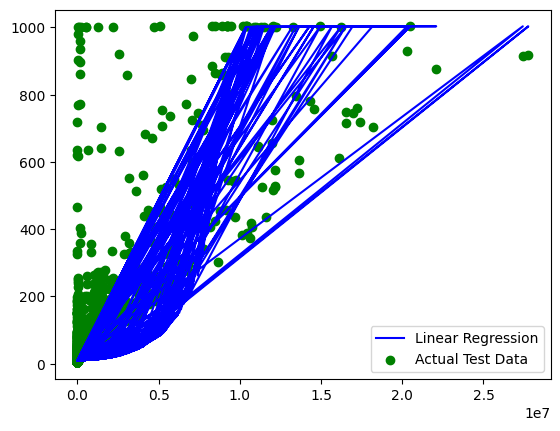

In [26]:
plt.plot(x_sr_test,prediction,label='Linear Regression',color='b')
plt.scatter(x_sr_test,y_sr_test,label='Actual Test Data',color='g')
plt.legend()
plt.show()

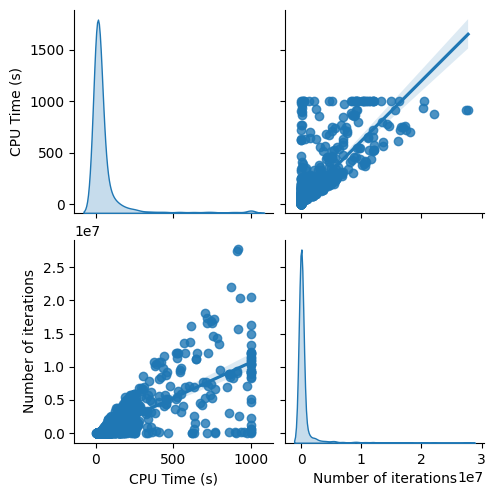

In [27]:
train_dataset = x_sr_train.copy()
train_dataset.insert(0, 'CPU Time (s)', y_sr_train)
_ = sns.pairplot(train_dataset, kind="reg", diag_kind="kde")
#plt.savefig('3_itcount_correlation.pdf')

### Train and test data

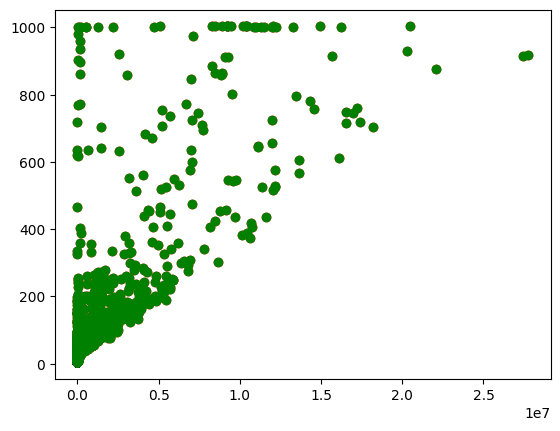

In [28]:
plt.scatter(x_sr_train,y_sr_train,color='r')
plt.scatter(x_sr_test,y_sr_test,color='g')
plt.show()

## Multiple Linear Regression

### Data Pre-Selection

In [29]:
prepared_data = data_clean
#prepared_data = prepared_data[['CPU Time (s)','Number of iterations']]

#Drop Text columns (status and verdict), Wall Time and: Memory,bc it is non-deterministic according to Martin, 'Number of target states' bc its discrete
prepared_data = prepared_data.drop(['status','Unnamed: 1','Wall Time (s)','Automaton transfer successors','Memory (MB)','Number of target states'],axis=1,errors='ignore')

#Pre-Selection
#prepared_data = prepared_data[['CPU Time (s)','Number of iterations','Avg size of partitions','Size of reached set','Number of computed successors','Number of unique precision increments','Number of program locations','Number of partitions']]
#remove correlated data
#'Number of computed successors' correlates with 'Number of iterations'
#prepared_data = prepared_data[['CPU Time (s)','Number of iterations','Avg size of partitions','Size of reached set','Number of unique precision increments','Number of program locations','Number of partitions']]


#Like in BA(do not delete): Baseline like Single linear regression
#prepared_data = prepared_data[['CPU Time (s)','Number of iterations']]

#Like in BA(do not delete): Manually chosen only: 'Number of program locations', 'Number of partitions' correlate with 'Size of reached set'
#prepared_data = prepared_data[['CPU Time (s)','Number of iterations','Avg size of partitions','Size of reached set','Number of unique precision increments']]

#Like in BA(do not delete): sfs-chosen only:
#prepared_data = prepared_data[['CPU Time (s)','Number of abstraction computations','Number of variables per state','Number of CFA edges (per node)','Max states per location']]

#Like in BA(do not delete): sfs-chosen AND manually chosen
#prepared_data = prepared_data[['CPU Time (s)','Number of iterations','Avg size of partitions','Size of reached set','Number of unique precision increments','Number of abstraction computations','Number of variables per state','Number of CFA edges (per node)','Max states per location']]

#prepared_data = prepared_data[['CPU Time (s)','Number of iterations','Avg size of partitions','Number of unique precision increments','Number of CFA edges (per node)']]

#Clean Datapoints that have NaN entries
prepared_data = prepared_data.dropna()

### Regression Pipeline

In [30]:
#LR =  LinearRegression()
LR = TransformedTargetRegressor(regressor=LinearRegression(),transformer=QuantileTransformer(n_quantiles=900, output_distribution="normal"))
pipeline = make_pipeline(StandardScaler(), LR)
#pipeline = make_pipeline(LR)

#CPU time is dependent variable
x_mr_df=prepared_data.drop(['CPU Time (s)'],axis=1)
y_mr_df=prepared_data['CPU Time (s)']

x_mr=x_mr_df.values
y_mr=y_mr_df.values
x_mr_df.head()

,Size of reached set,Number of iterations,Number of abstraction computations,Number of variables per state,Number of global variables per state,Number of assumptions,Number of deterministic assumptions,Level of Determinism (%),Replaced symbolic expressions,Number of states,...,Number of relevant variables,Number of functions,Number of loops (and loop nodes),Number of reached locations,Avg states per location,Max states per location,Number of reached functions,Number of partitions,Avg size of partitions,Max size of partitions
../programs/benchmarks/,,,,,,,,,,,,,,,,,,,,,
reducercommutativity/rangesum05.yml,142.0,401.0,434.0,1.07,0.0,422.0,0.0,0.0,0.0,1.0,...,15.0,4.0,3.0,38.0,3.0,18.0,4.0,62.0,2.0,6.0
reducercommutativity/rangesum10.yml,244.0,605.0,638.0,1.14,0.0,742.0,0.0,0.0,0.0,1.0,...,15.0,4.0,3.0,38.0,6.0,33.0,4.0,62.0,3.0,11.0
reducercommutativity/rangesum20.yml,454.0,1025.0,1058.0,1.19,0.0,1382.0,0.0,0.0,0.0,1.0,...,15.0,4.0,3.0,38.0,11.0,63.0,4.0,62.0,7.0,21.0
reducercommutativity/rangesum40.yml,874.0,1865.0,1898.0,1.21,0.0,2662.0,0.0,0.0,0.0,1.0,...,15.0,4.0,3.0,38.0,23.0,123.0,4.0,62.0,14.0,41.0
reducercommutativity/rangesum60.yml,1294.0,2705.0,2738.0,1.22,0.0,3942.0,0.0,0.0,0.0,1.0,...,15.0,4.0,3.0,38.0,34.0,183.0,4.0,62.0,20.0,61.0


#### --> Train-Test-Split?

In [31]:
#x_mr_train,x_mr_test,y_mr_train,y_mr_test=train_test_split(x_mr_df, y_mr_df, test_size=0.3)
x_mr_train,x_mr_test,y_mr_train,y_mr_test=x_mr_df,x_mr_df,y_mr_df,y_mr_df

feature_names = np.array(x_mr_train.columns)

#### Sequential Feature Selection

In [32]:
sfs_forward = SequentialFeatureSelector(
    pipeline, n_features_to_select=5, direction="forward"
).fit(x_mr_train, y_mr_train)

print(
    "Features selected by forward sequential selection: "
    f"{feature_names[sfs_forward.get_support()]}"
)

Features selected by forward sequential selection: ['Number of iterations' 'Size of interpolant' 'Total conditions'
 'Number of reached locations' 'Avg size of partitions']


#### --> All x variables or the ones selected by sfs?

In [33]:
#x_selected = x_mr_train
x_selected = x_mr_train[feature_names[sfs_forward.get_support()]]

feature_names = np.array(x_selected.columns)

#### K-Fold Cross Val Score

In [34]:
scores = cross_val_score(pipeline, x_selected, y_mr_train, cv=5)
print("%0.2f determination coefficient with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.27 determination coefficient with a standard deviation of 0.26


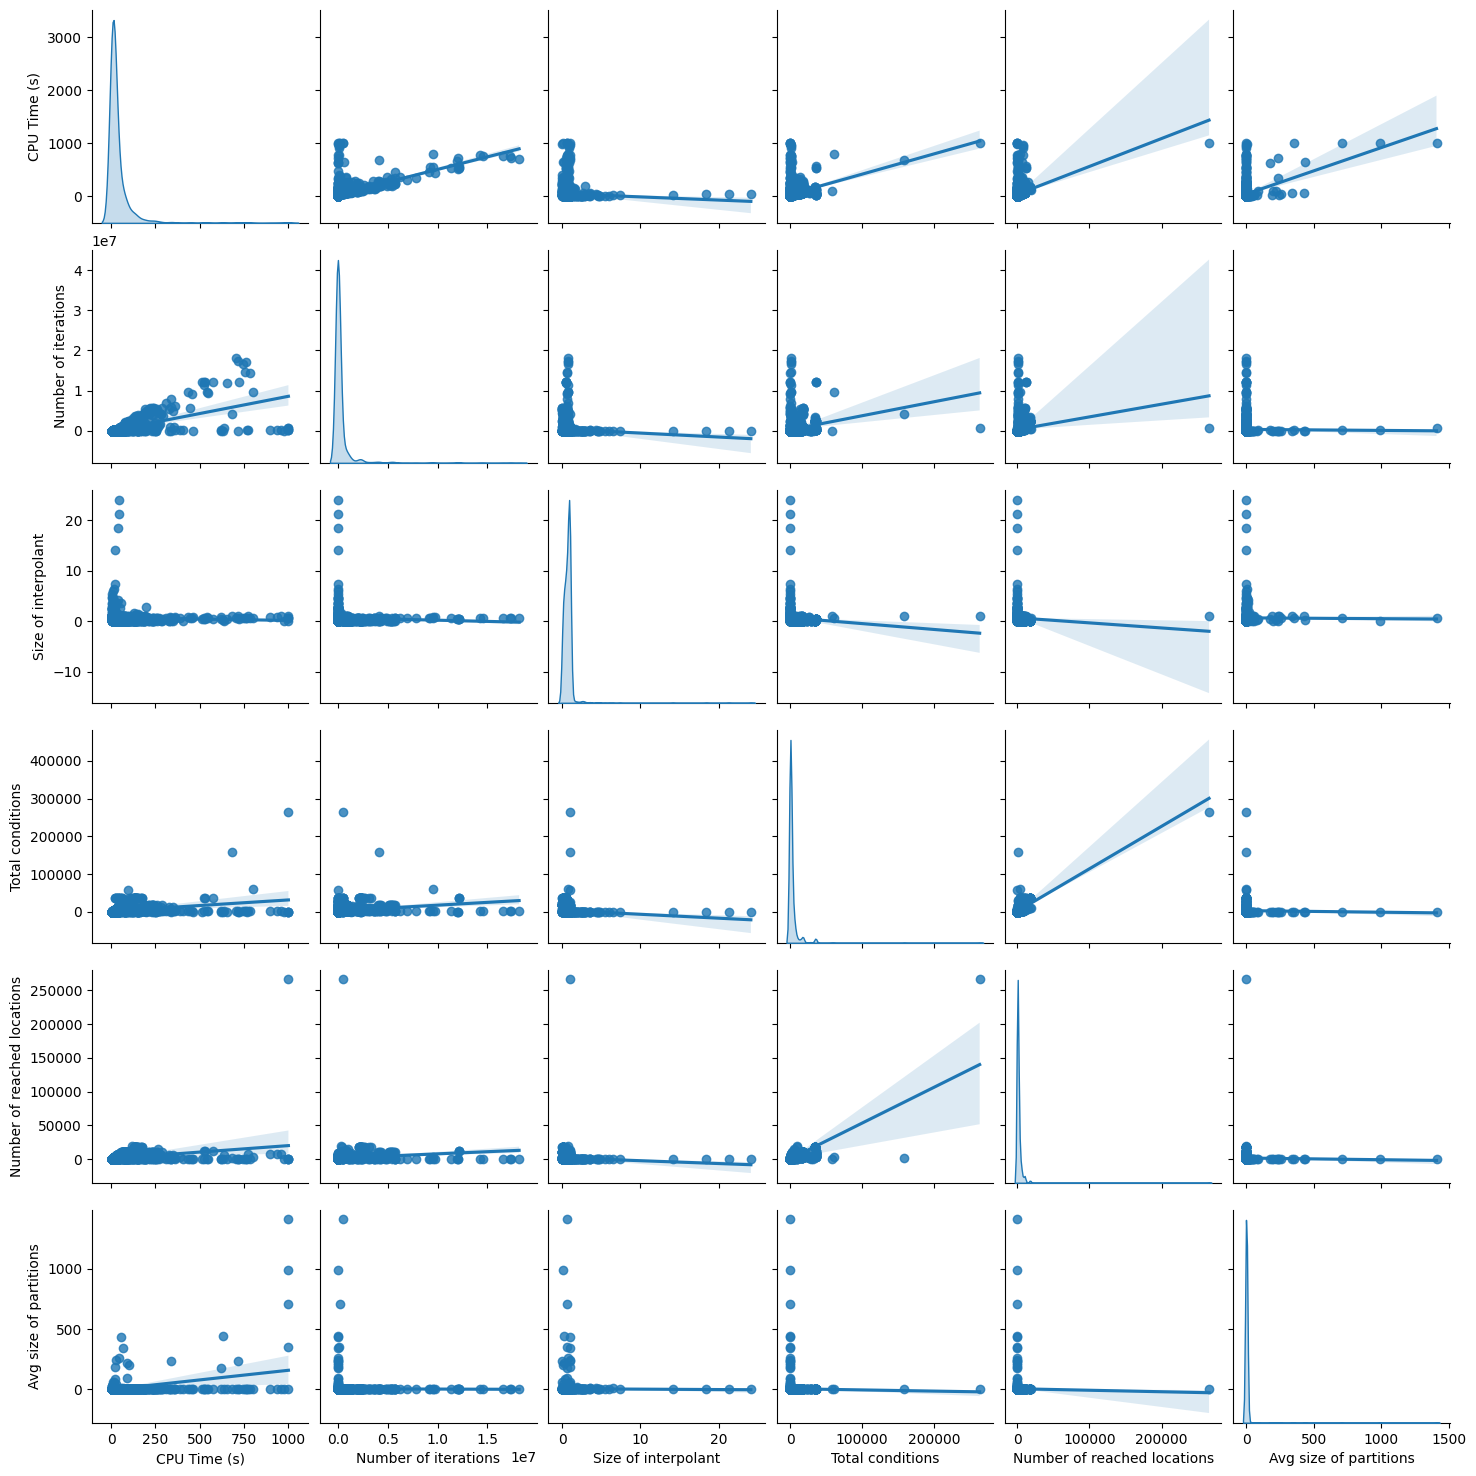

In [35]:
train_dataset = x_selected.copy()
train_dataset.insert(0, 'CPU Time (s)', y_mr_df)
_ = sns.pairplot(train_dataset, kind="reg", diag_kind="kde")

#### Coefficient importance with K-Fold CV

In [36]:
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)
cv_model = cross_validate(
    pipeline,
    x_selected,
    y_mr_df,
    cv=cv,
    return_estimator=True,
)

coefs = pd.DataFrame(
    [
        est[-1].coef_ * est[:-1].transform(x_selected.iloc[train_idx]).std(axis=0)
        for est, (train_idx, _) in zip(cv_model["estimator"], cv.split(x_selected, y_mr_df))
    ],
    columns=feature_names,
)

plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")
plt.subplots_adjust(left=0.3)

AttributeError: 'TransformedTargetRegressor' object has no attribute 'coef_'

#### Features by Regression Coefficient (NOT K-Fold Coefficients)

In [37]:
pipeline.fit(x_selected,y_mr_train)
#prediction = pipeline.predict(x_mr_test)

importance = np.abs(pipeline['linearregression'].coef_)
plt.figure(num=None, figsize=(20,18), dpi=80, facecolor='w', edgecolor='r')
plt.barh(width=importance, y=feature_names)
plt.title("Feature importances via coefficients")
plt.show()

KeyError: 'linearregression'

### Statsmodels analysis

In [ ]:
X2 = sm.add_constant(x_mr_df)
est = sm.OLS(y_mr_df, X2)
est2 = est.fit()
print(est2.summary())

## Correlation between two metrics

In [ ]:
x='Number of iterations'
y='Size of reached set'
slr = LinearRegression()
slr.fit(prepared_data[x].values.reshape(-1,1),prepared_data[y].values)
prediction = slr.predict(prepared_data[x].values.reshape(-1,1))

plt.plot(prepared_data[x].values,prediction,label='Linear Regression',color='b')
plt.scatter(prepared_data[x].values, prepared_data[y].values)
plt.show()

In [ ]:
slr.score(prepared_data[x].values.reshape(-1,1),prepared_data[y].values)